In [3]:
import numpy as np
import pandas as pd
from spec_id import RT_spec,Gen_spec
import matplotlib.pyplot as plt
from vtl.Readfile import Readfile
from glob import glob
from astropy.io import fits, ascii
from astropy.table import Table
from scipy.interpolate import interp1d
from time import time
import os
import cPickle
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [23]:
def Theta(age,tau):
    return np.exp(-age/tau)

def Avg_age(AGE,TAU):
    top=TAU+np.exp(AGE/TAU)*(AGE-TAU)
    bottom=np.exp(AGE/TAU)-1
    return top/bottom

In [24]:
age = np.arange(0,4.1,.1)
tau = np.arange(0,10,.001)

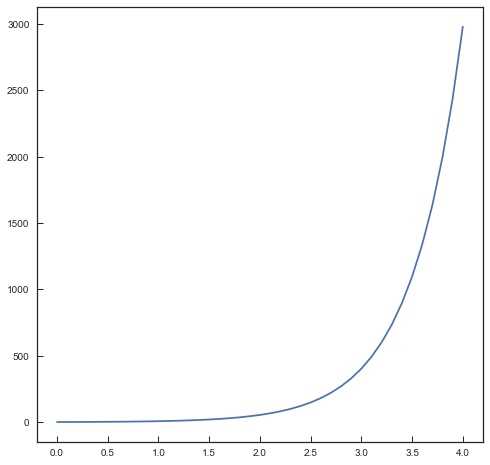

In [27]:
%matplotlib inline

plt.figure(figsize=[8,8])
plt.plot(age,1/Theta(age,.5))
plt.show()
plt.close()

3.91490818718


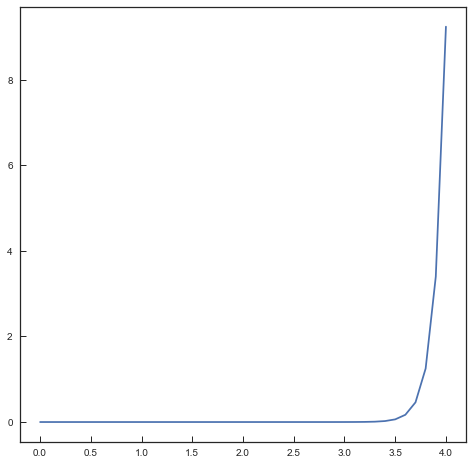

In [22]:
%matplotlib inline

C = np.trapz(np.exp(age/.1),age)
print np.trapz(np.exp(age/.1)*age/C,age)
plt.figure(figsize=[8,8])
# plt.plot(age,(4-np.exp(-age/.1))/C)
plt.plot(age,np.exp(age/.1)/C)
plt.show()
plt.close()

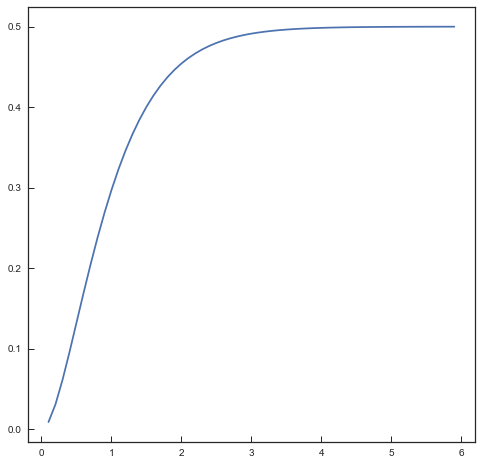

In [35]:
%matplotlib inline

plt.figure(figsize=[8,8])
plt.plot(age,0.5-np.exp(-age/.5)*(.5 + age))
plt.show()
plt.close()

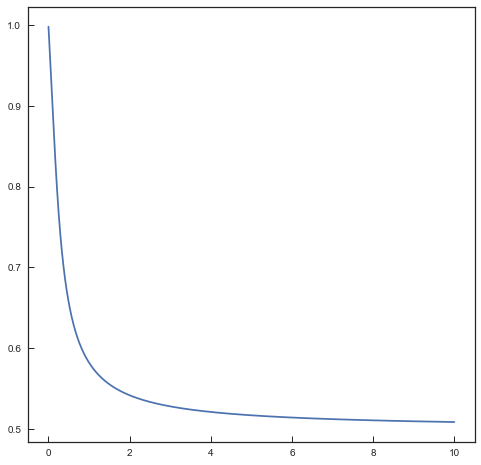

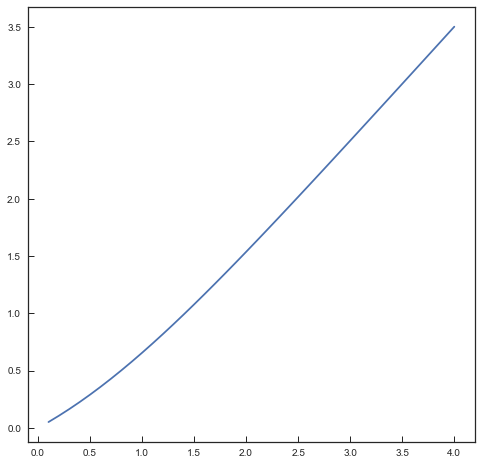

In [26]:
%matplotlib inline

plt.figure(figsize=[8,8])
plt.plot(tau,Avg_age(1,tau))
plt.show()
plt.close()

plt.figure(figsize=[8,8])
plt.plot(age,Avg_age(age,.5))
plt.show()
plt.close()